In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
from study_abc_noise.model import ConversionReactionLaplaceModelVars as ModelVars
import matplotlib.pyplot as plt
%matplotlib inline

## Iterations plot with true density for one n_t

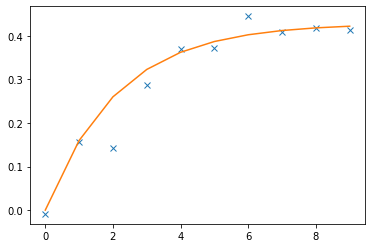

In [2]:
n_t = 10

mv = ModelVars(n_t=n_t)
model = mv.get_model()
prior = mv.get_prior()
data = {'y': np.load(f"data/data_laplace_{n_t}.npy")}

plt.plot(data['y'], 'x')
plt.plot(mv.get_model()(mv.p_true)['y'])

In [3]:
def laplace_dty_1d(y_obs, y, sigma):
    dty = ( 1 / (2 * sigma)
            * np.exp(- abs(y_obs - y) / sigma) )
    return dty

def laplace_dty(y_obs, y, sigma):
    dty = np.prod(1 / (2*sigma) * np.exp(-np.abs(y_obs-y)/sigma))
    return dty

uniform_pd = 1 / ((mv.limits['p0'][1] - mv.limits['p0'][0])
                  * (mv.limits['p1'][1] - mv.limits['p1'][0]))

def posterior_unscaled(p):
    if type(p) is not dict:
        p = {key: p[i] for i, key in enumerate(mv.p_true)}

    y = model(p)['y'].flatten()
    sigma = mv.noise_std * np.ones(mv.n_t)
    
    # likelihood
    likelihood_val = laplace_dty(data['y'], y, sigma)
    
    # prior
    prior_val = prior.pdf(p)

    return likelihood_val * prior_val

def get_posterior_scaled():
    total = sp.integrate.dblquad(
        lambda p1, p0: posterior_unscaled([p0, p1]),
        mv.limits['p0'][0], mv.limits['p0'][1],
        lambda p1: mv.limits['p1'][0],
        lambda p1: mv.limits['p1'][1], epsabs=1e-1, epsrel=1e-1
    )
    print("total: ", total)
    return lambda p: posterior_unscaled(p) / total[0]

posterior = get_posterior_scaled()

def marg_p0(p0):
    return sp.integrate.quad(
        lambda p1: posterior([p0, p1]),
            mv.limits['p1'][0], mv.limits['p1'][1])[0]

def marg_p1(p1):
    return sp.integrate.quad(
        lambda p0: posterior([p0, p1]),
            mv.limits['p0'][0], mv.limits['p0'][1])[0]

/home/yannik/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


total:  (816057.2254266867, 4841410.804689832)


In [4]:
h = pyabc.History(f"sqlite:///cr_laplace_{n_t}_stochacc.db")
print(h.observed_sum_stat())
print(data)

p0s = np.linspace(mv.limits['p0'][0], 0.15, 100)
val0s = [marg_p0(p0) for p0 in p0s]

p1s = np.linspace(mv.limits['p1'][0], 0.15, 100)
val1s = [marg_p1(p1) for p1 in p1s]

{'y': array([-0.00876848,  0.15648884,  0.14265824,  0.28638945,  0.36976445,
        0.37119272,  0.44501694,  0.40913655,  0.41837688,  0.41388495])}
{'y': array([-0.00876848,  0.15648884,  0.14265824,  0.28638945,  0.36976445,
        0.37119272,  0.44501694,  0.40913655,  0.41837688,  0.41388495])}


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on t

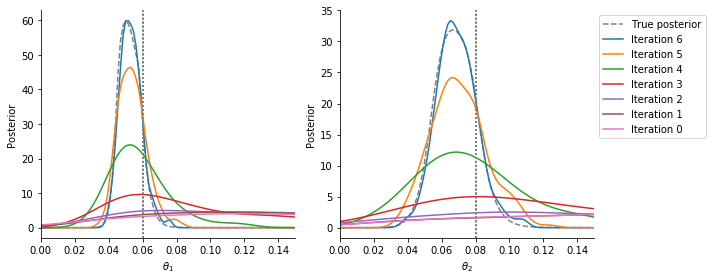

In [5]:
h = pyabc.History(f"sqlite:///cr_laplace_{n_t}_stochacc.db")

fig, arr_ax = plt.subplots(1, 2)

arr_ax[0].plot(p0s, val0s, '--', color='grey')
arr_ax[1].plot(p1s, val1s, '--', label="True posterior", color='grey')

for ip, p in enumerate(['p0', 'p1']):
    for t in reversed(range(0, h.max_t+1)):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=p, xmin=mv.limits[p][0], xmax=0.15, numx=100,
            refval=mv.p_true, refval_color='grey', ax=arr_ax[ip], label=f"Iteration {t}",
            #color='C0', alpha=1/(h.max_t-t+1)
        )

arr_ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

for i, ax in enumerate(arr_ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(f"$\\theta_{i+1}$")

fig.set_size_inches((10, 4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_laplace_{n_t}_alltimes.{fmt}", format=fmt)

## Some analysis for what to compare

In [6]:
arr_n_t = [3, 10, 30, 100, 300, 1000]
arr_approach = ['stochacc', 'stochacc_badc', 'rejection', 'rejection_badc', 'noisymodel']
#arr_approach = ['stochacc', 'stochacc_badc', 'rejection', 'noisymodel']
approach_legends = ["ABC-SMC, stoch. acc.", "ABC-SMC, stoch. acc., bad $c$", "ABC-Rejection, stoch. acc.", "ABC-Rejection, stoch. acc., bad c", "Noisy model"]
mv = ModelVars()

max_ts = [None, None, None, None, None, None, None, None]

arr_hs = []
success = []

for i, n_t in enumerate(arr_n_t):
    arr_hs.append([])
    success.append([])
    for approach in arr_approach:
        f = f"cr_laplace_{n_t}_{approach}.db"
        if not os.path.isfile(f):
            arr_hs[i].append(None)
            success[i].append(False)
            continue
        _h = pyabc.History(f"sqlite:///{f}")
        arr_hs[i].append(_h)
        last_eps = _h.get_all_populations()['epsilon'].iloc[-1]
        success[i].append(True if (approach == 'noisymodel' and max_ts[i] is not None) or last_eps == 1.0 else False)
        if not success[i][-1]: print("Failure: ", approach, n_t)


success = np.array(success)
total_samples = []
for i, (n_t, max_t) in enumerate(zip(arr_n_t, max_ts)):
    total_samples.append([])
    for j, approach in enumerate(arr_approach):
        h = arr_hs[i][j]
        if h is None:
            total_samples[i].append(None)
            print(f"t={n_t} {approach} missing")
        else:
            s = h.get_all_populations()['samples']
            if j == 3 and max_t is not None:
                total_samples[i].append(np.sum(s[:max_t+1]))
            else:
                total_samples[i].append(np.sum(h.get_all_populations()['samples']))

total_samples = np.array(total_samples)
max_samples = np.max(total_samples)

Failure:  rejection_badc 3
Failure:  noisymodel 3
Failure:  stochacc_badc 10
Failure:  rejection_badc 10
Failure:  noisymodel 10
Failure:  stochacc_badc 30
Failure:  rejection_badc 30
Failure:  noisymodel 30
Failure:  stochacc_badc 100
Failure:  rejection 100
Failure:  rejection_badc 100
Failure:  noisymodel 100
Failure:  stochacc_badc 300
Failure:  rejection 300
Failure:  rejection_badc 300
Failure:  noisymodel 300
Failure:  stochacc_badc 1000
Failure:  rejection_badc 1000
Failure:  noisymodel 1000


## Choice of max_t for noisy models

3
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
10
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
30
  stochacc
  stochacc_badc
  rejection
  noisymodel


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


  stochacc
  stochacc_badc
  rejection
  noisymodel
100
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
300
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel
1000
  stochacc
  stochacc_badc
  rejection
  noisymodel
  stochacc
  stochacc_badc
  rejection
  noisymodel


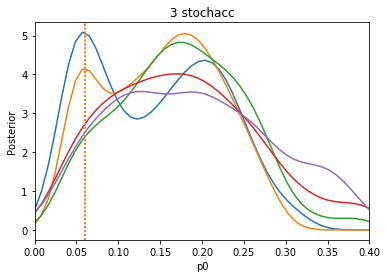

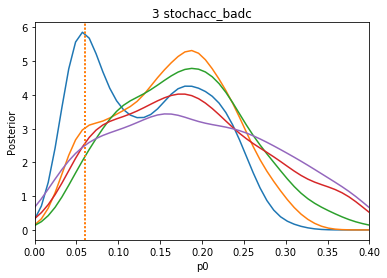

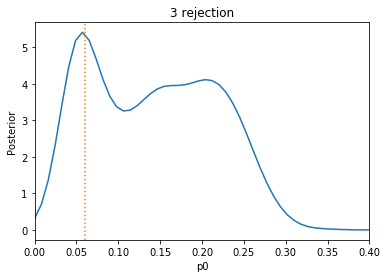

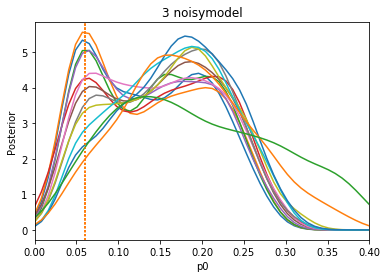

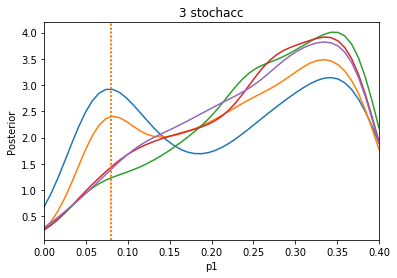

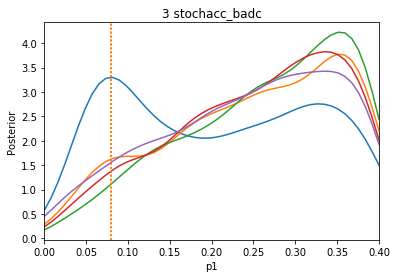

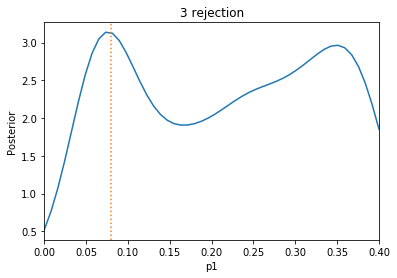

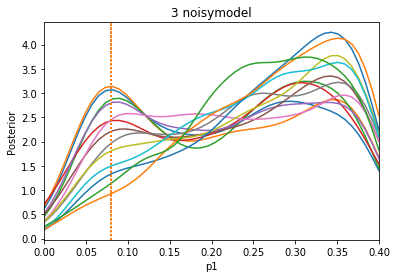

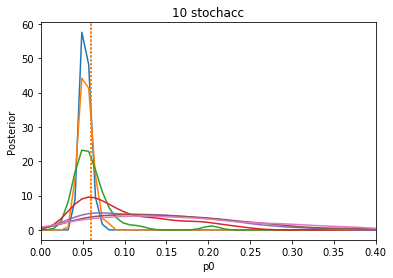

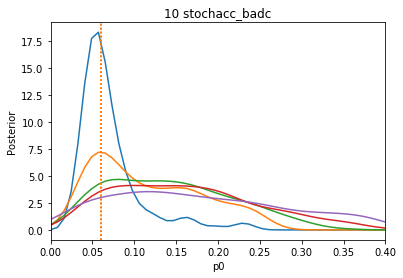

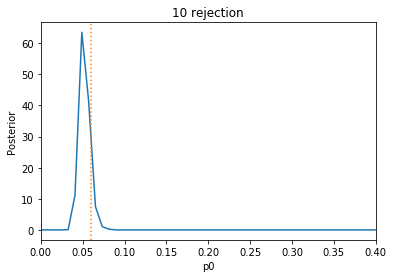

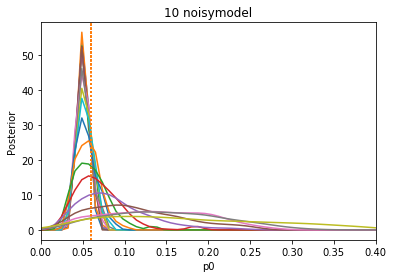

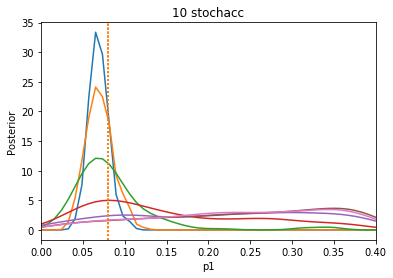

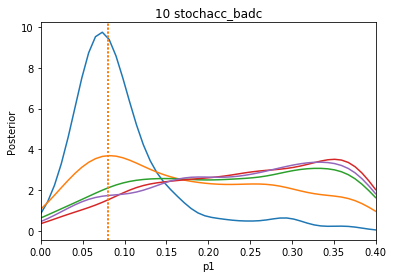

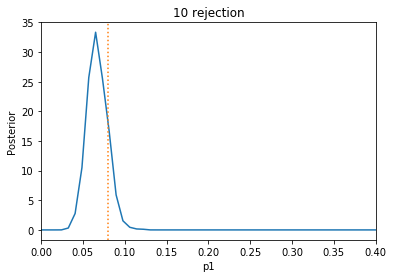

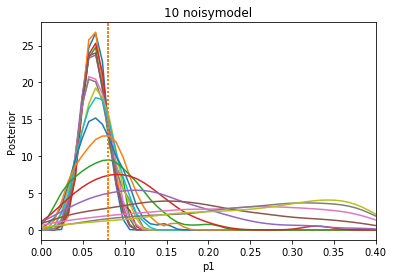

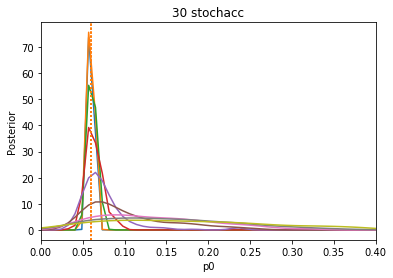

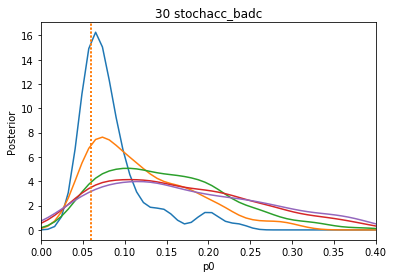

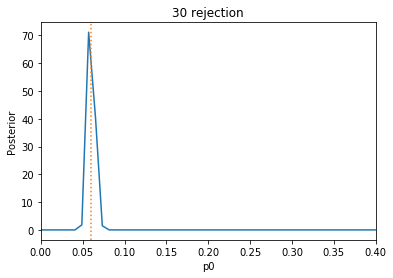

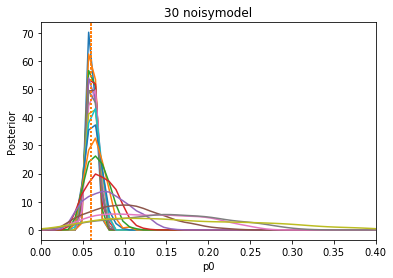

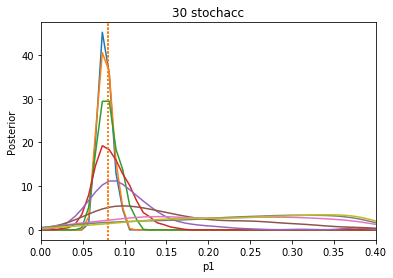

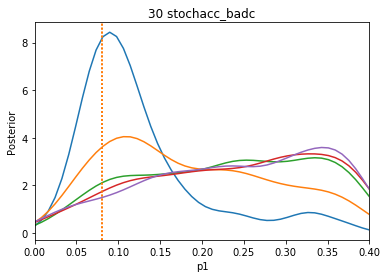

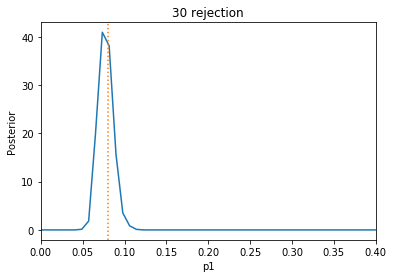

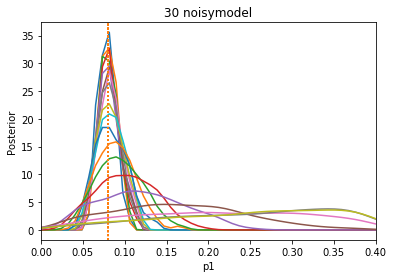

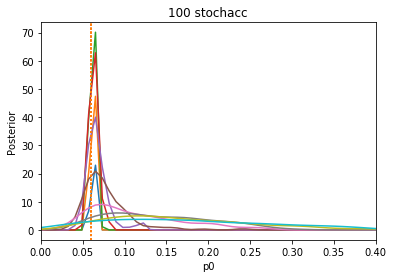

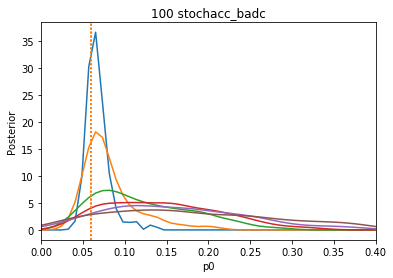

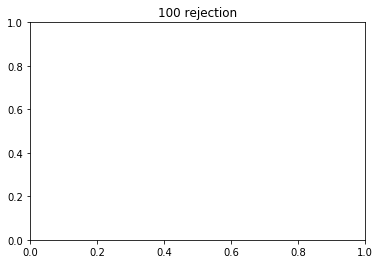

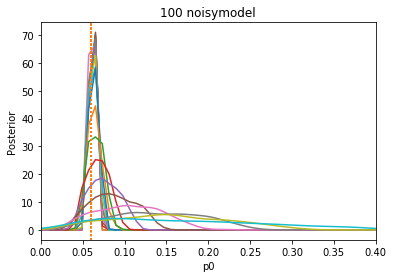

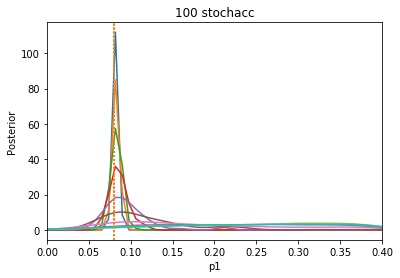

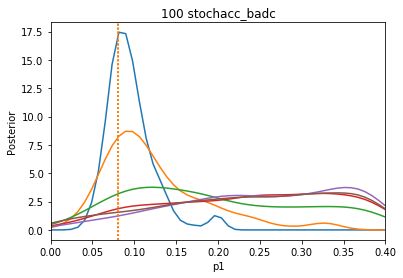

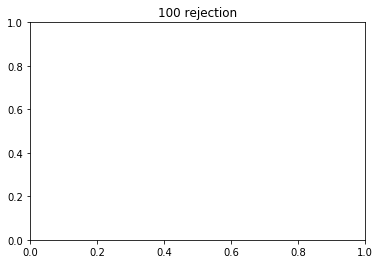

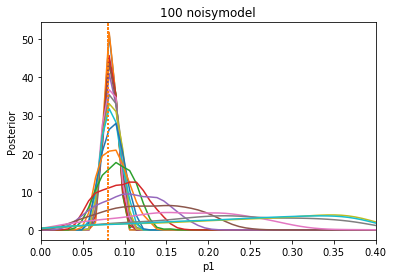

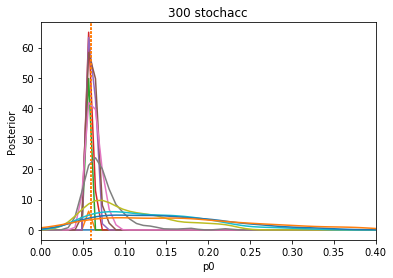

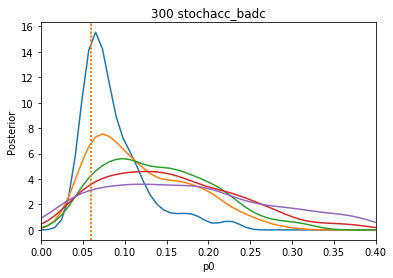

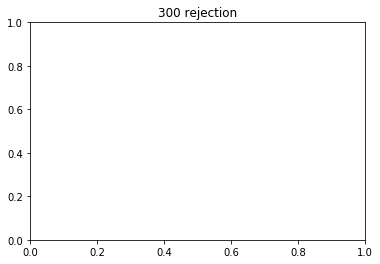

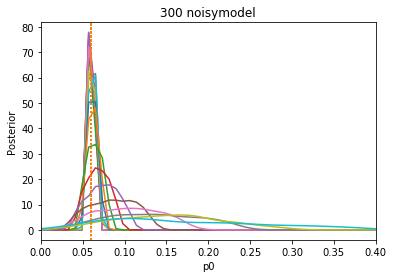

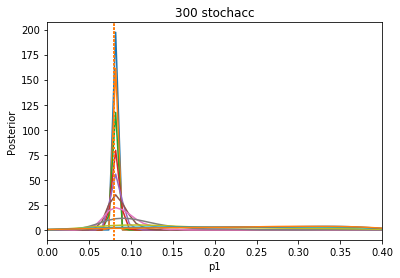

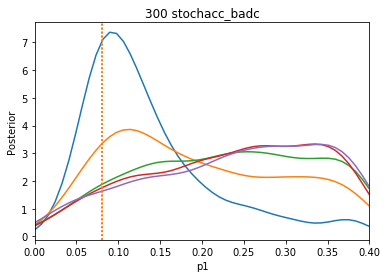

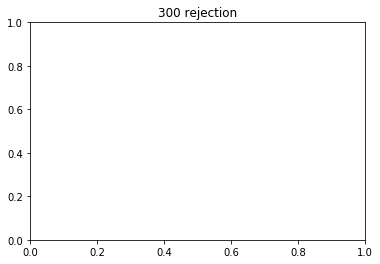

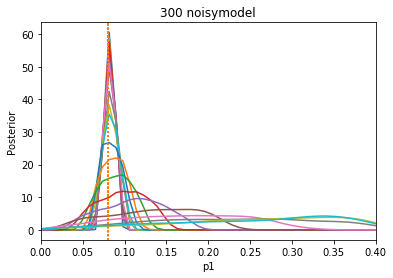

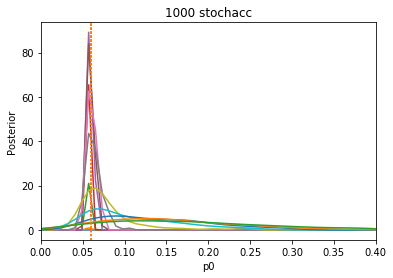

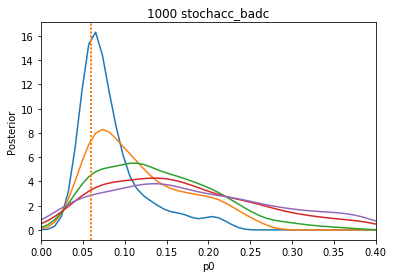

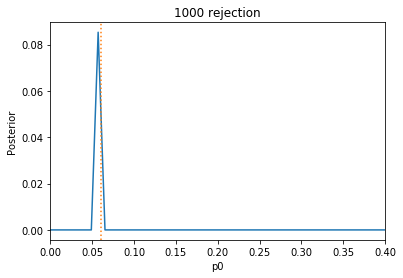

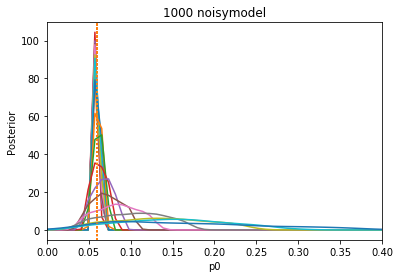

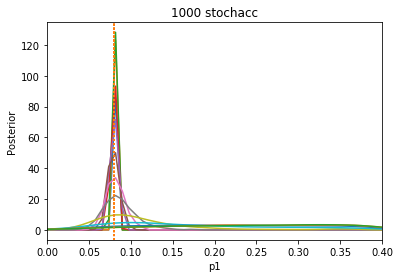

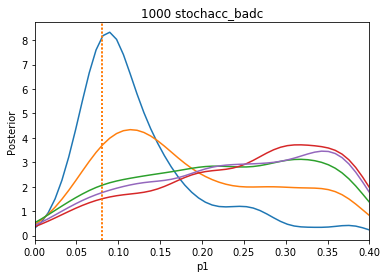

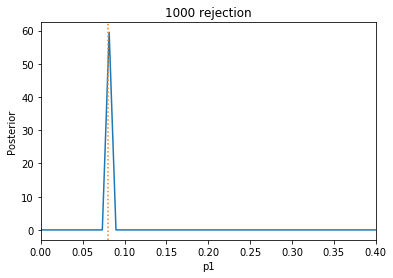

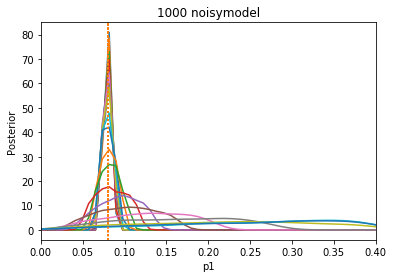

In [45]:
for t, hs in zip(arr_n_t, arr_hs):
    print(t)
    #_, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            _, ax = plt.subplots()
            print(" ", approach)
            for _t in reversed(range(0, h.max_t + 1)):
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t, 
                    ax=ax, refval=mv.p_true)
            plt.title(f"{t} {approach}")
            #ax.legend()

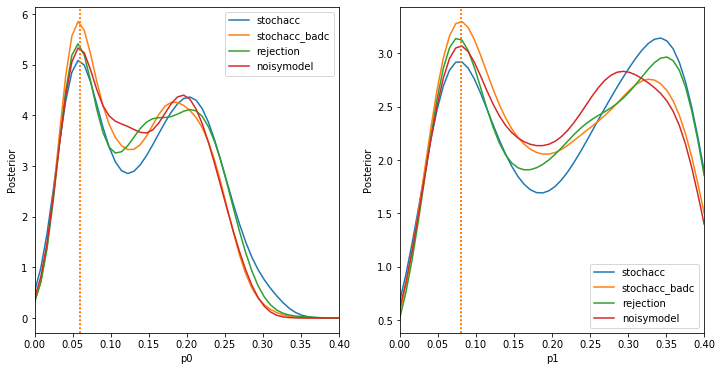

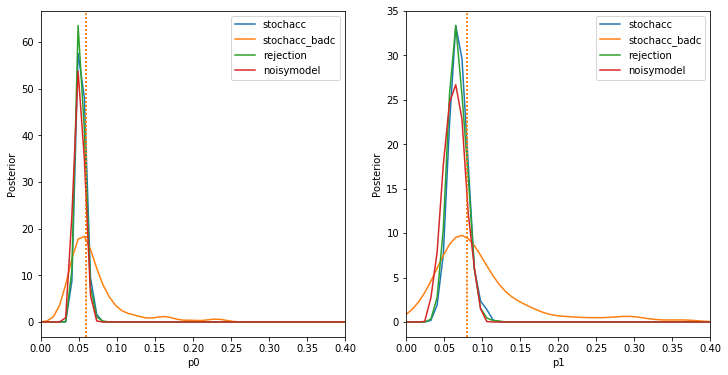

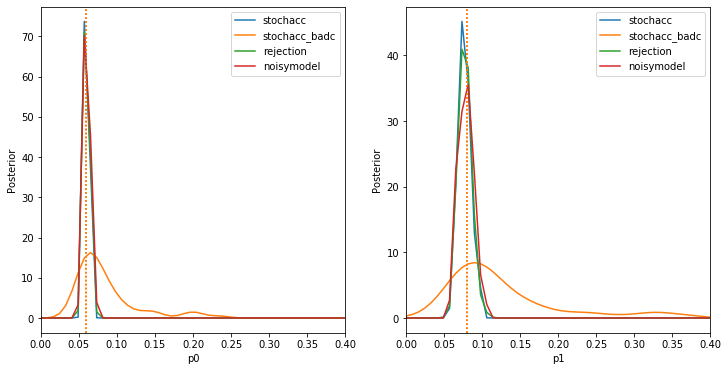

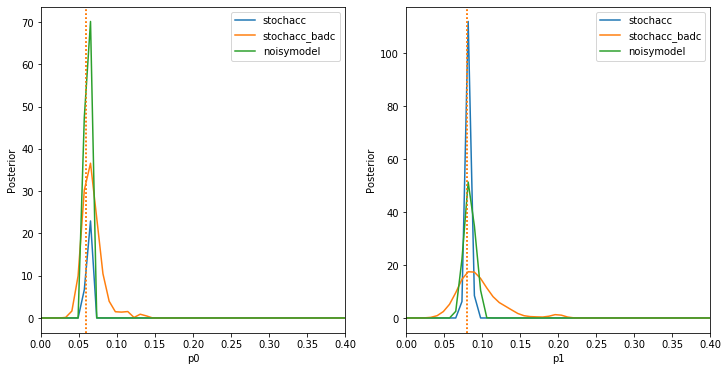

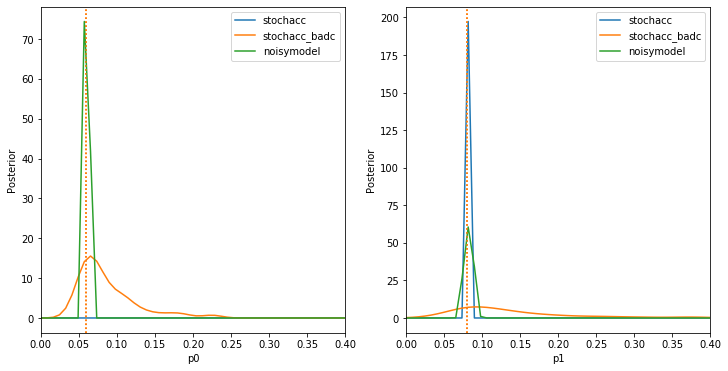

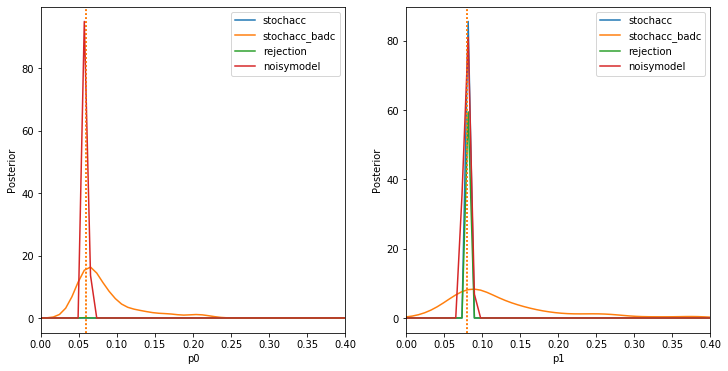

In [85]:
for t, hs in zip(arr_n_t, arr_hs):
    _, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            if h.max_t >= 0:
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, 
                    ax=ax[ip], refval=mv.p_true, label=approach)
        ax[ip].legend()
    plt.gcf().set_size_inches((12, 6))

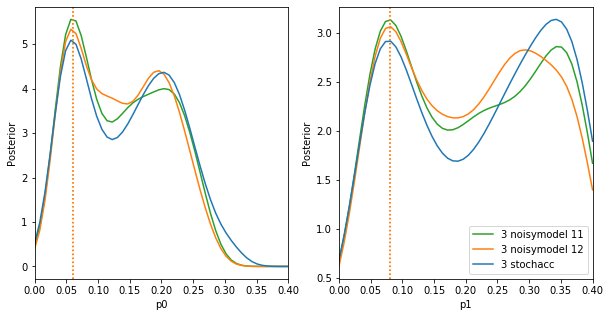

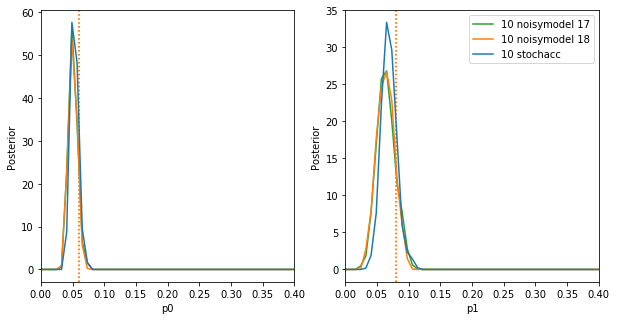

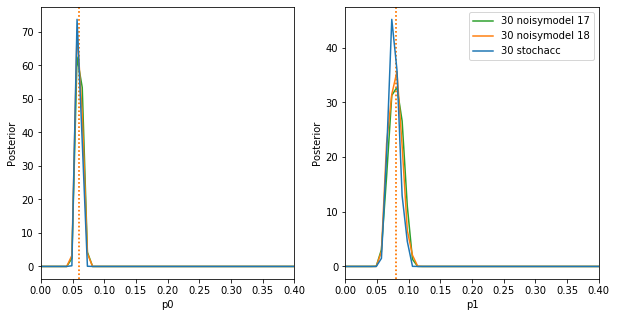

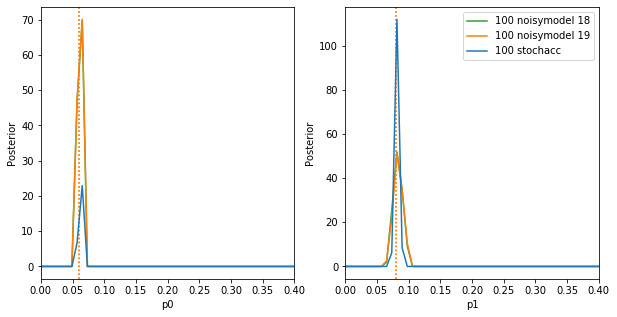

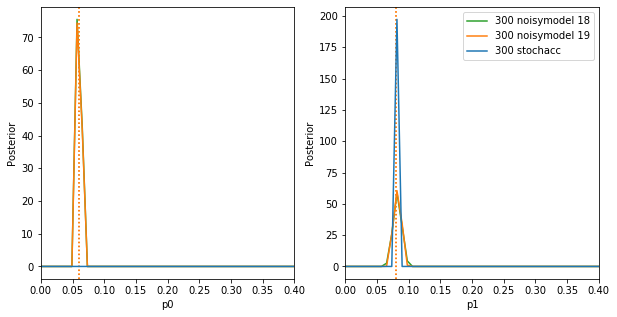

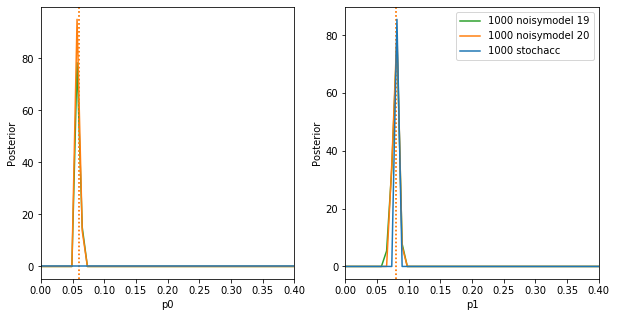

In [58]:
for t, hs, _t in zip(arr_n_t, arr_hs, [None, None, None, None, None, None, None, None]):
    _, ax = plt.subplots(1, 2)
    h = hs[3]
    if _t is None:
        _t = h.max_t
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t-1,
            ax=ax[ip], refval=mv.p_true, label=f"{t} noisymodel {_t-1}", color='C2')
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t,
            ax=ax[ip], refval=mv.p_true, label=f"{t} noisymodel {_t}", color='C1')
    h = hs[0]
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None,
            ax=ax[ip], label=f"{t} stochacc", color='C0')
    plt.legend()
    plt.gcf().set_size_inches((10, 5))

## Bar plot comparison over the n_ts

In [63]:
print(total_samples)

[[  57856  207676   50102 1796410]
 [  52904       0  578643 2161951]
 [  44529       0  842092 2104457]
 [  55548       0       0 1954144]
 [  61426       0       0 1320559]
 [  66446       0  792639 1329565]]


Text(0, 0.5, 'Total number of samples')

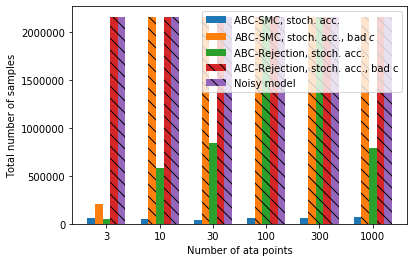

In [84]:
_, ax = plt.subplots()

maxi = np.max(total_samples)

barwidth = 1 / (len(arr_approach) + 2)
for i, approach in enumerate(approach_legends):
    _samples = total_samples[:, i]
    _success = success[:, i]
    for j, _s in enumerate(_success):
        if not _s:
            _samples[j] = maxi
    p = np.arange(len(arr_n_t)) + (i+0.5-len(arr_approach)/2) * barwidth
    barc = ax.bar(p, _samples, width=barwidth, label=approach)
    for j, _s in enumerate(_success):
        if not _s:
            barc.patches[j].set_hatch('\\\\')
#ax.set_yscale('log')
ax.set_xticks(np.arange(len(arr_n_t)))
ax.set_xticklabels(arr_n_t)
ax.legend(loc='upper right')
#ax.set_ylim([1e-2, 1e6])
ax.set_xlabel("Number of ata points")
#ax.set_ylabel("log(Total number of samples)")
ax.set_ylabel("Total number of samples")

3 57856 24678 132056.58431218262 7.979309133315207 9.656627474604601 5.35118665662463 0.7284501000170993
10 52904 3999 241175577.99048862 21.181522091950264 32.18875824868201 60308.971740557296 4.780381923874553
30 44529 2680 1.8753572939185743e+18 62.38451594763281 96.56627474604605 699760184297975.5 14.844949227898795
100 55548 2766 4.360458319760867e+41 233.9341740152412 321.8875824868199 1.5764491394652446e+38 38.19767996378934
300 61426 3093 6.549436298705123e+130 672.4842031592418 965.66274746046 2.1175028447155264e+127 127.32582400244709


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


1000 66446 2999 inf 2212.382536800521 3218.8758248681997 inf 437.11448108045295


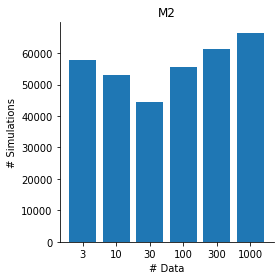

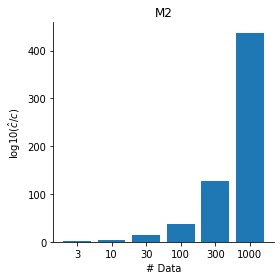

In [10]:
factors = []
log10_factors = []
arr_n_t = [3,10,30,100,300,1000]
n_d = len(arr_n_t)
arr_total_samples_assa = []

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    kernel = mv.get_kernel()
    data = {'y': np.load(f"data/data_laplace_{n_t}.npy")}
    kernel.initialize(0, None, data)
    # the (too high) maximum density
    c_hat = kernel.pdf_max
    
    log_file = f"log/log_acceptor_cr_laplace_{n_t}_stochacc.json"
    df = pyabc.storage.load_dict_from_json(log_file)
    # the last (highest) used adaptive c (could be computed by optimization)
    c = df[max(df.keys())]
    
    h = pyabc.History(f"sqlite:///cr_laplace_{n_t}_stochacc.db", create=False)
    # number of samples in the last iteration
    samples = np.array(h.get_all_populations()['samples'])[-1]
    total_samples = sum(h.get_all_populations()['samples'])
    arr_total_samples_assa.append(total_samples)
    
    factor = np.exp(c_hat - c)
    factors.append(factor)
    
    # numerics
    log10_factor = (c_hat - c) * np.log10(np.exp(1))
    log10_factors.append(log10_factor)
    
    samples_prediction = np.exp(c_hat - c) * samples
    print(n_t, total_samples, samples, samples_prediction, c, c_hat, samples_prediction / samples, log10_factor)
    
fig, ax = plt.subplots()
ax.bar(np.arange(n_d), arr_total_samples_assa)
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("# Simulations")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("M2")
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_laplace_datapoint_scaling_samples.{fmt}", format=fmt)
    
fig, ax = plt.subplots()
ax.bar(np.arange(n_d), log10_factors)
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("log10($\hat c / c$)")
ax.set_title("M2")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_laplace_datapoint_scaling.{fmt}", format=fmt)

In [3]:
for n_t in [3,10,30,100,300,1000]:
    mv = ModelVars(n_t=n_t)
    kernel = mv.get_kernel()
    data = {'y': np.load(f"data/data_laplace_{n_t}.npy")}
    kernel.initialize(0, None, data)
    c_bar = kernel.pdf_max
    
    log_file = f"log/log_acceptor_cr_laplace_{n_t}_stochacc.json"
    df = pyabc.storage.load_dict_from_json(log_file)
    c = df[max(df.keys())]
    
    h = pyabc.History(f"sqlite:///cr_laplace_{n_t}_stochacc.db", create=False)
    samples = np.array(h.get_all_populations()['samples'])[-1]
    total_samples = sum(h.get_all_populations()['samples'])
    
    samples_prediction = np.exp(c_bar - c) * samples
    print(n_t, total_samples, samples, samples_prediction, c, c_bar, samples_prediction / samples)

3 57856 24678 132056.58431218262 7.979309133315207 9.656627474604601 5.35118665662463
10 52904 3999 241175577.99048862 21.181522091950264 32.18875824868201 60308.971740557296
30 44529 2680 1.8753572939185743e+18 62.38451594763281 96.56627474604605 699760184297975.5
100 55548 2766 4.360458319760867e+41 233.9341740152412 321.8875824868199 1.5764491394652446e+38
300 61426 3093 6.549436298705123e+130 672.4842031592418 965.66274746046 2.1175028447155264e+127
1000 66446 2999 inf 2212.382536800521 3218.8758248681997 inf


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


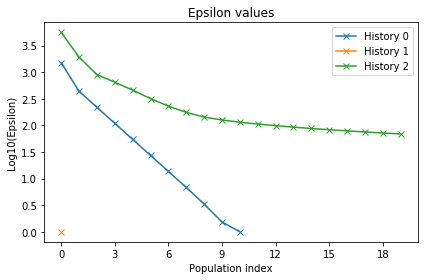

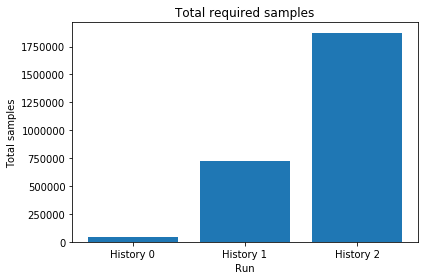

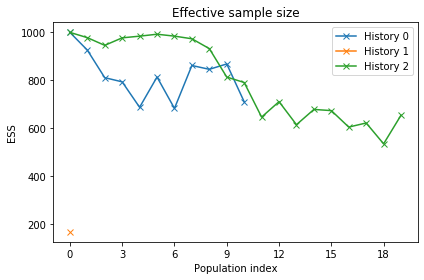

In [8]:
pyabc.visualization.plot_epsilons(hs[60], scale='log10')
pyabc.visualization.plot_total_sample_numbers(hs[60], yscale='lin')
pyabc.visualization.plot_effective_sample_sizes(hs[60])


[<pyabc.storage.history.History object at 0x7f5b62c1a470>, <pyabc.storage.history.History object at 0x7f5b62d332e8>, <pyabc.storage.history.History object at 0x7f5b62ed9668>, <pyabc.storage.history.History object at 0x7f5b62ed9be0>]


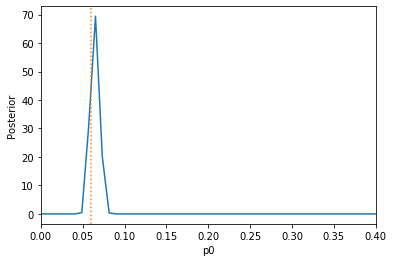

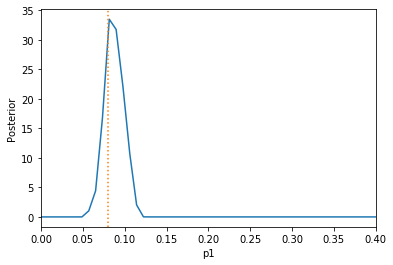

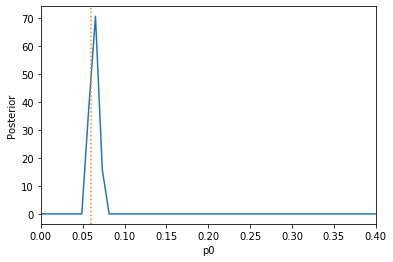

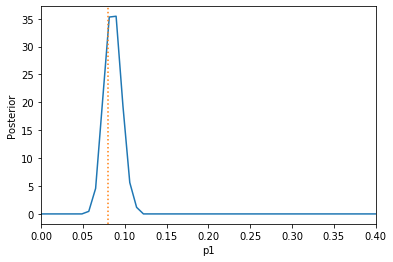

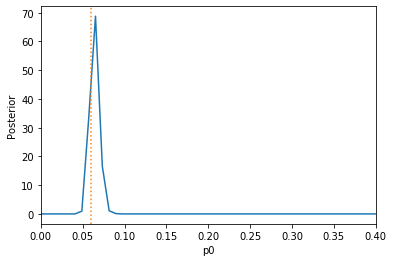

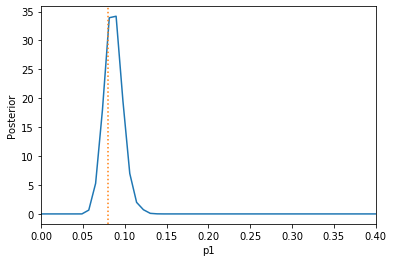

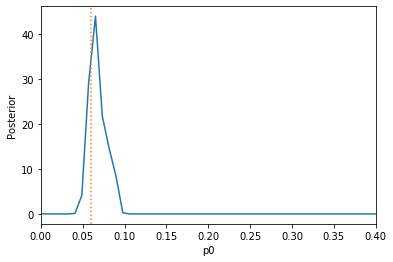

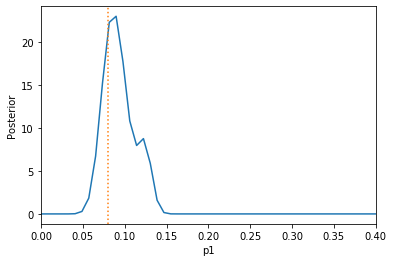

In [15]:
print(hs[2])
def plot_posterior(_h):
    for p in mv.p_true:
        _, ax = plt.subplots()
        #for t in range(_h.max_t+1):
        pyabc.visualization.plot_kde_1d_highlevel(
            _h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, ax=ax, refval=mv.p_true)

for i in range(4):
    plot_posterior(hs[2][i])


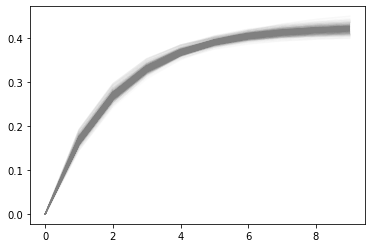

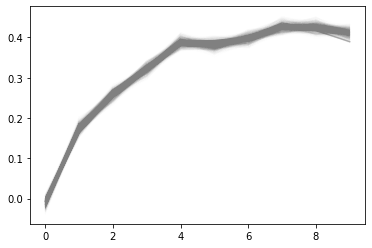

In [4]:
def plot_data(sum_stat, weight, ax, **kwargs):
    ax.plot(sum_stat['y'], color='grey', alpha=5*weight)
    
pyabc.visualization.plot_data_callback(hs[10][0], plot_data)
pyabc.visualization.plot_data_callback(hs[10][2], plot_data)

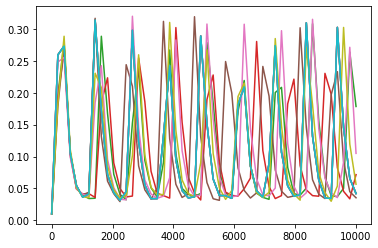

In [7]:
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars
import matplotlib.pyplot as plt

mv = ModelVars(basedir="..")
for _ in range(10):
    d = mv.get_model()(mv.p_true)
    plt.plot(d['K'])